In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path('/content/drive/MyDrive/Classification')

In [4]:
# Here we have the 2637 train and 660 test
image_count_train = len(list(data_dir_train.glob('*/*.JPG')))
print("The number of Train data:",image_count_train)

The number of Train data: 2152


In [5]:
# This Parameter we can use it in the network and model
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# For train data set
train_ds = image_dataset_from_directory(data_dir_train)
                                       

Found 2152 files belonging to 3 classes.


In [7]:
labels =  train_ds.class_names
labels

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(train_ds)

68

In [9]:
for batch, classes in train_ds.take(1):
    print(batch.shape)
    print(len(labels))

(32, 256, 256, 3)
3


In [10]:
import matplotlib.pyplot as plt

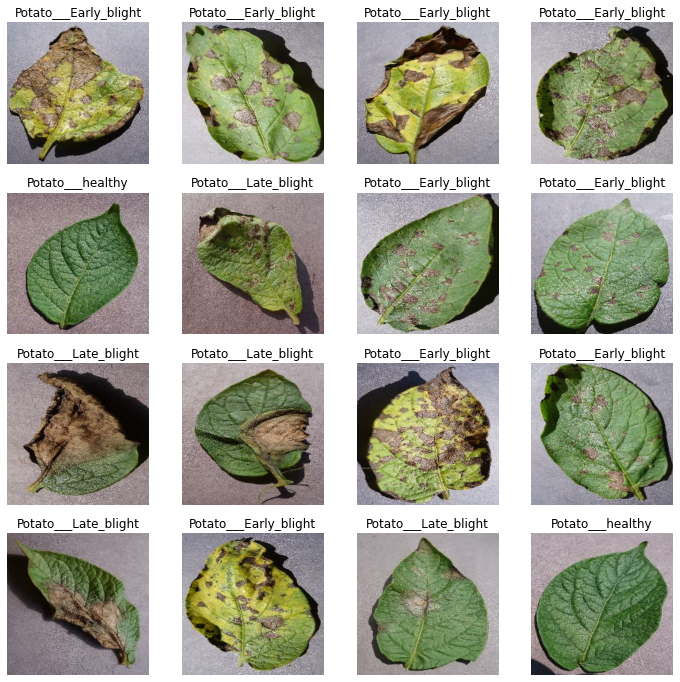

In [11]:
plt.figure(figsize=(12, 12))

for batch, classes in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(batch[i].numpy().astype('uint32'))
        plt.title(labels[classes[i].numpy()])
        plt.axis('off')

In [12]:
training_data = train_ds.take(int(len(train_ds)*0.8))
len(training_data)

54

In [13]:
testing_data = train_ds.skip(54)
len(testing_data)

14

In [14]:
val_data = testing_data.take(int(len(train_ds)*0.1))
len(val_data)

6

In [15]:
testing_data = testing_data.skip(6)
len(testing_data)

8

In [16]:
from tensorflow.data import AUTOTUNE

In [17]:
training_data = training_data.cache().shuffle(1000).prefetch(AUTOTUNE)
val_data = val_data.cache().shuffle(500).prefetch(AUTOTUNE)
testing_data = testing_data.cache().shuffle(256).prefetch(AUTOTUNE)

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.models import Sequential

In [19]:
resizing_and_rescaling_layers = Sequential([
                                            Resizing(256, 256),
                                            Rescaling(1/255.0)
                                        ])

# Data Augmentation

In [20]:

from tensorflow.keras.layers.experimental.preprocessing import RandomZoom, RandomRotation


In [21]:
augmentation_layers = Sequential([
                                    RandomZoom(0.6),
                                    RandomRotation(0.34),
                                ])

# Model Training

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


In [23]:
model = Sequential([
    resizing_and_rescaling_layers,
    augmentation_layers,
    Conv2D(32, 3, activation='relu', input_shape=(32, 256, 256, 3)),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(128, 'relu'),
    Dense(32, 'relu'),
    Dense(3, 'softmax'),
    
])

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
model.build((32, 256, 256, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

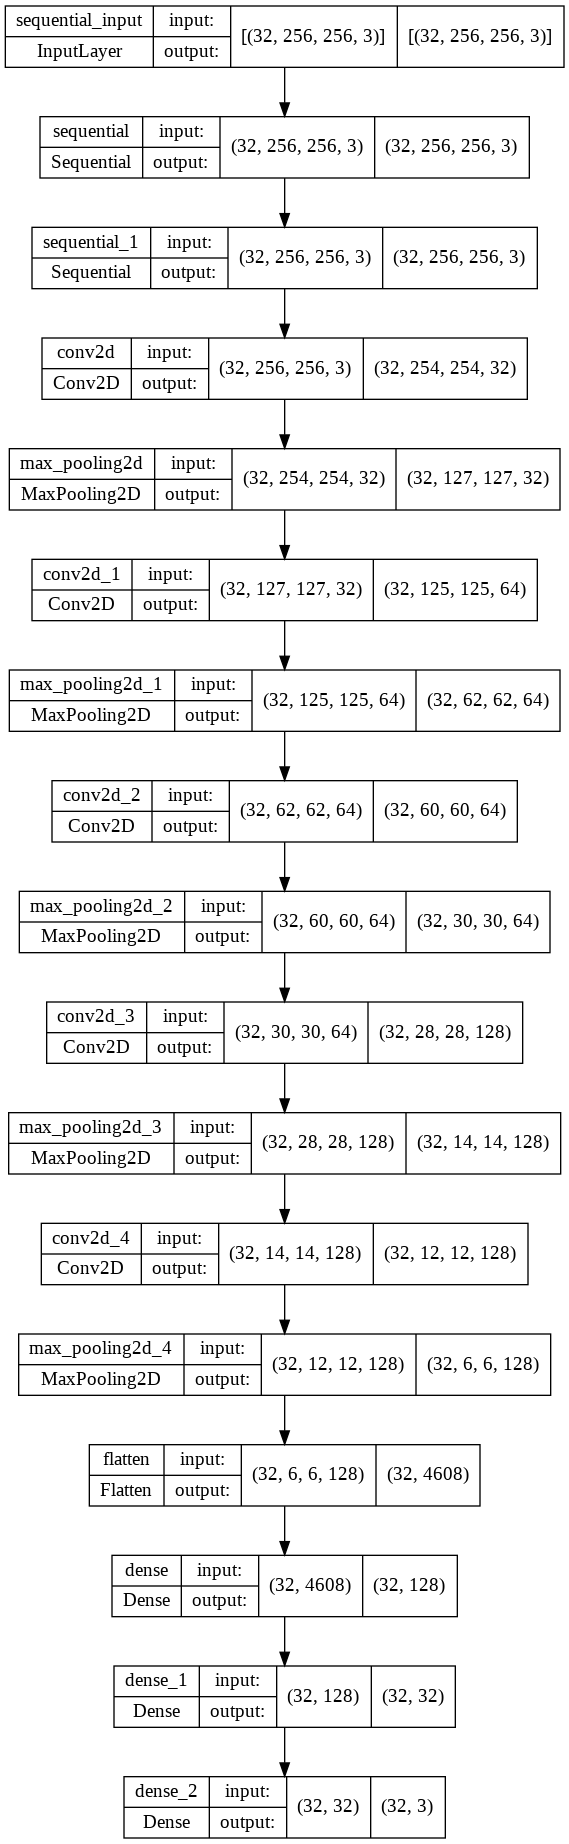

In [26]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-plant.png', show_shapes=True)

In [27]:
model.compile(
    'Adam',
    'SparseCategoricalCrossentropy',
    ['accuracy']
)

In [28]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=6, restore_best_weights=True)

In [29]:
history = model.fit(
    training_data,
    epochs=4,
    validation_data=val_data,
    callbacks=[early_stopping]
)

Epoch 1/4
54/54 [==============================] - 412s 786ms/step - loss: 0.8997 - accuracy: 0.4861 - val_loss: 0.7519 - val_accuracy: 0.5833
Epoch 2/4
54/54 [==============================] - 4s 71ms/step - loss: 0.7741 - accuracy: 0.6458 - val_loss: 0.6204 - val_accuracy: 0.7604
Epoch 3/4
54/54 [==============================] - 4s 71ms/step - loss: 0.5361 - accuracy: 0.7818 - val_loss: 0.3151 - val_accuracy: 0.8698
Epoch 4/4
54/54 [==============================] - 4s 71ms/step - loss: 0.4109 - accuracy: 0.8397 - val_loss: 0.3553 - val_accuracy: 0.8698


# Model Testing and Performance Plotting

In [30]:
preformance = model.evaluate(testing_data)

8/8 [==============================] - 4s 31ms/step - loss: 0.3552 - accuracy: 0.8621


In [31]:
preformance

[0.3551897406578064, 0.8620689511299133]

In [32]:
history.params

{'epochs': 4, 'steps': 54, 'verbose': 1}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.4861111044883728,
 0.6458333134651184,
 0.7818287014961243,
 0.8396990895271301]

In [35]:
no_of_epochs = history.params['epochs']
len(history.history['accuracy']) == no_of_epochs

True

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

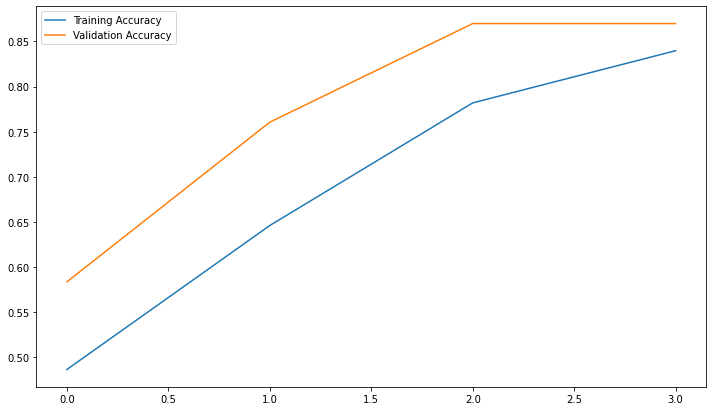

In [37]:
plt.figure(figsize=(12, 7))

plt.plot(range(no_of_epochs), acc, label='Training Accuracy')
plt.plot(range(no_of_epochs), val_acc, label='Validation Accuracy')

plt.legend()
plt.show()

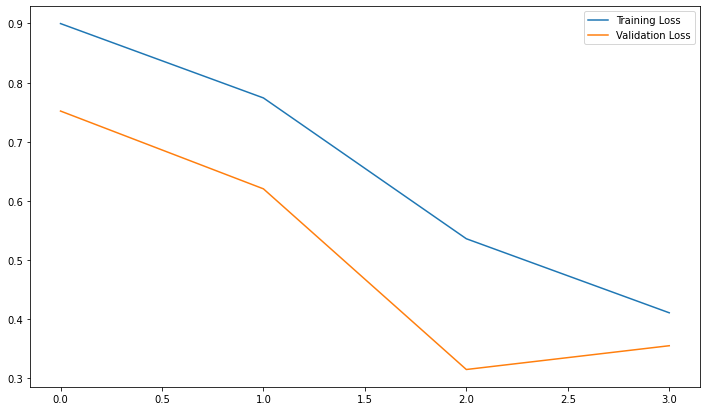

In [38]:
plt.figure(figsize=(12, 7))

plt.plot(range(no_of_epochs), loss, label='Training Loss')
plt.plot(range(no_of_epochs), val_loss, label='Validation Loss')

plt.legend()
plt.show()

# Prediction / Inference

actual label: Potato___Late_blight
predicted label: Potato___Late_blight


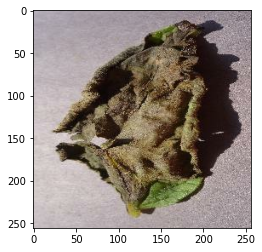

In [44]:
for images_batch, labels_batch in testing_data.take(1):
    
    image = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    
    plt.imshow(image)
    print("actual label:", labels[label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", labels[np.argmax(batch_prediction[0])])

In [45]:
from tensorflow import expand_dims, newaxis

def predict(model, img):
    
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

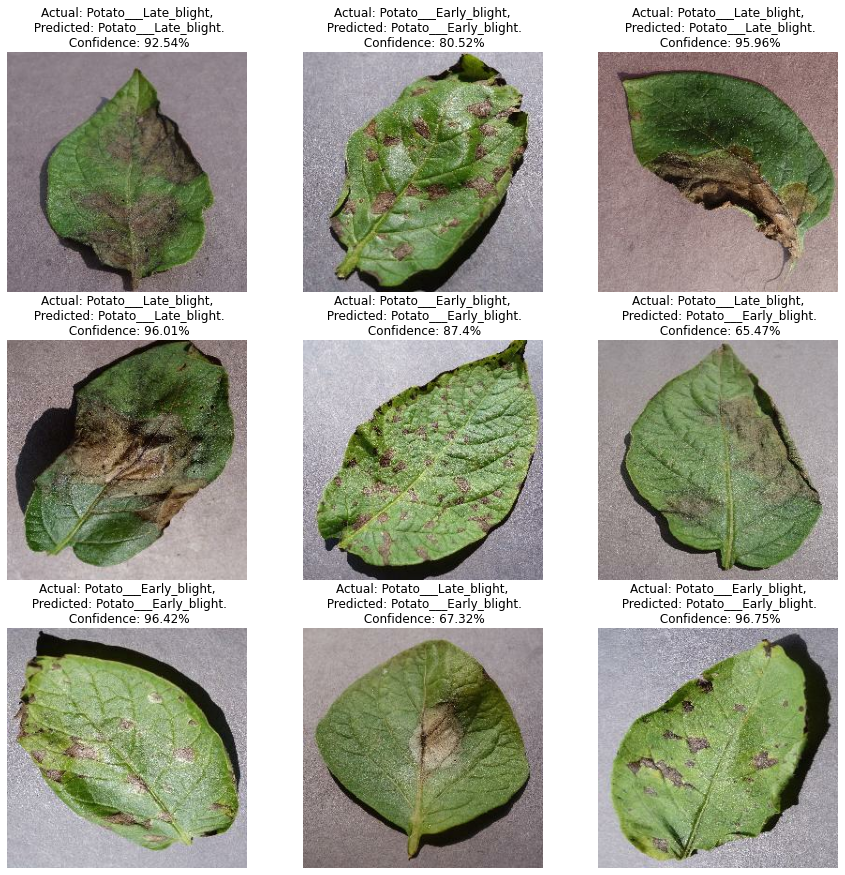

In [46]:
plt.figure(figsize=(15, 15))

for images, lbs in testing_data.take(1):
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# save / export the model

In [47]:
os.mkdir('models')

In [48]:
last_version = max([int(i) for i in os.listdir('models')+[0]])
os.mkdir(f'models/{last_version+1}')

In [49]:
model.save(f'models/{last_version+1}')

INFO:tensorflow:Assets written to: models/1/assets


# Model Deployment

In [50]:
import os

os.chdir('/content/drive/MyDrive/Classification')

In [51]:
try: os.mkdir('api')
except: pass

# Server Testing

In [53]:
pip install FastAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 80 kB 8.2 MB/s 


In [54]:
from fastapi import FastAPI
# from fastapi.middleware.cors import CORSMiddleware

In [55]:
app = FastAPI(title = 'Potato Disease Classification')

In [58]:
@app.get("/") # Endpoint Creating

def ping():
    return "Hello from here We can see the classification model here for potato plant."

In [60]:
pip install uvicorn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 


In [61]:
import uvicorn
import nest_asyncio

In [62]:
nest_asyncio.apply()

# uvicorn.run(app, host='localhost', port=8000)

In [63]:
from tensorflow.keras.models import load_model

In [65]:
latest_update_version = max(int(i) for i in os.listdir('/content/models'))

In [67]:
model = load_model(f'/content/models/{latest_update_version}')
model

# Putting the software required for predicting in a Server

In [68]:
from fastapi import File, UploadFile
from io import BytesIO

from PIL import Image
import numpy as np

from tensorflow import newaxis


In [69]:
class_names = ['Early Blight', 'Late Blight', 'Healthy']

In [70]:
def read_file_as_image(data) -> np.ndarray:
    image = np.array(Image.open(BytesIO(data)))
    return image

In [72]:
pip install python-multipart

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=bb6f844c03280e4bc825719a9b062f4dc6db25e3fc3812a7ec5c72dc9bd5d755
  Stored in directory: /root/.cache/pip/wheels/2c/41/7c/bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
Successfully built python-multipart


In [73]:
@app.post("/predict")

async def predict(file: UploadFile = File(...)):
    
    image = read_file_as_image(await file.read())
    
    img_batch = np.expand_dims(image, 0)

    prediction = model.predict(img_batch)
    
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    return {
        "class": predicted_class,
        "confidence": float(confidence)
    }